### This approach is actually mimo (after verifying associated literature). I was wrong to think it was miso.

In [35]:
import os
import pandas as pd
import numpy as np
from numpy import mean, std, absolute
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import scipy as sp
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
from sklearn.preprocessing import normalize
import shap


plt.style.use('ggplot')
shap.initjs()

## Load Data

In [2]:
data = pd.read_excel('Data/Gasification Data_Daya.xlsx', index_col=0, header=0)
data = data.iloc[1:223,:14] 
display(list(data.columns.values))

# Drop null balues and store dataframe in dataframe 2
data=data.dropna()
print(data)

#Check Null values again after removing
print(data.isnull().values.any())
print(data.isna().values.any())

X = data.iloc[:, :9]
y = data.iloc[:, 9:]

input_columns = list(X.columns.values)
input_columns = [i.split(' [', 1)[0] for i in input_columns]
output_columns = list(y.columns.values)
output_columns = [i.split(' [', 1)[0] for i in output_columns]
print(input_columns, output_columns)

Xvals = X.values
yvals = y.values
print(Xvals.shape, yvals.shape)

Xnorm = np.zeros_like(Xvals)
ynorm = np.zeros_like(yvals)
for idx in range(len(input_columns)):
    Xnorm[:, idx] = (Xvals[:,idx]-min(Xvals[:,idx]))/(max(Xvals[:,idx])-min(Xvals[:,idx]))
for odx in range(len(output_columns)):
    ynorm[:, odx] = (yvals[:,odx]-min(yvals[:,odx]))/(max(yvals[:,odx])-min(yvals[:,odx]))

print(np.max(Xnorm), np.max(ynorm))
print(np.min(Xnorm), np.min(ynorm))

['C [%wt db]',
 'H [%wt db]',
 'O [%wt db]',
 'Moisture [%wt]',
 'Ash [%wt db]',
 'ER [-]',
 'T [ºC]',
 'Bed material',
 'Steam/Biomass',
 'H2 [%vol N2 free]',
 'CO [%vol N2 free]',
 'CO2 [%vol N2 free]',
 'CH4 [%vol N2 free]',
 'GY [Nm3/kg daf]']

        C [%wt db] H [%wt db]  O [%wt db] Moisture [%wt]  Ash [%wt db]  \
Sr No.                                                                   
2            50.00        5.7       44.10             21          0.85   
3            50.00        5.7       44.10             23          0.85   
4            50.00        5.7       44.10             22          0.85   
5            50.00        5.7       44.10             25          0.85   
6            50.00        5.7       44.10             19          0.85   
...            ...        ...         ...            ...           ...   
219          46.85        6.3       45.55              9          1.30   
220          46.85        6.3       45.55              9          1.30   
221          46.76       5.68       39.46           9.94          8.10   
222          46.76       5.68       39.46           9.94          8.10   
223          46.76       5.68       39.46           9.94          8.10   

        ER [-]  T [ºC]  Bed material 

In [ ]:
print(Xnorm)

## Classify the data using ensemble regressor

In [3]:
seed = 42
X_train, X_test, y_train, y_test = train_test_split(Xnorm, ynorm, test_size=.3, random_state=seed)

# For Gradient Boost
prediction = np.zeros_like(y_test)
gbm = {}
for idx in range(y.shape[1]):
    gbm[idx] = GradientBoostingRegressor(n_estimators=1000, learning_rate=.1, random_state=seed, loss='huber')
    gbm[idx].fit(X_train, y_train[:, idx])
    prediction[:, idx]=gbm[idx].predict(X_test)
error = np.sqrt(mse(y_test, prediction, multioutput='raw_values'))
r2value = r2(y_test, prediction, multioutput='raw_values')
print(error, r2value)

[0.05761345 0.09006027 0.06814227 0.05010572 0.04366575] [0.86368865 0.74413933 0.82973299 0.86112012 0.89660094]


## Plot Results

### 1. Correlation analysis between the input features and continuous outputs 

In [11]:
result_folder = 'XAI_results/'
if not os.path.exists(result_folder):
    os.mkdir(result_folder)

In [ ]:
## Correlation analysis for best feature
plt.figure(figsize=(50, 50))
row = len(input_columns)
column = len(output_columns)
for idx, inp in enumerate(input_columns):
    for odx, out in enumerate(output_columns):
        plt.subplot(row, column, 5*idx+odx+1)
        plt.scatter(Xnorm[:, idx], ynorm[:, odx], s=50, color='black')
        slope, intercept, r, p, stderr = sp.stats.linregress(Xnorm[:, idx].astype(float), 
                                                             ynorm[:, odx].astype(float))
        line = f'y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
        plt.plot(Xnorm[:, idx], intercept + slope * Xnorm[:, idx], label=line, color='red')
        plt.xlabel("Input Feature: \n%s" % inp, fontsize=16)
        plt.ylabel("Output Feature: \n%s" % out, fontsize=16)
        plt.legend(loc='upper left')
plt.savefig(result_folder + 'Correlation_analysis.pdf')
plt.clf()

### 2. True vs Estimated plots for each test samples

In [ ]:
plt.figure(figsize=(15, 30))
for odx, out in enumerate(output_columns):
    plt.subplot(5, 1, odx +1)
    plt.plot(np.asarray(y_test)[:, odx], label='True value', color='blue')
    plt.plot(np.asarray(prediction)[:, odx], color='red', 
             label='Predicted value \n (RMSE = %.4f, R2=%.3f)' % (error[odx], (r2value[odx])))
    plt.xlabel("Features", fontsize=16)
    plt.ylabel("Values", fontsize=16)
    plt.rc('xtick',labelsize=14)
    plt.rc('ytick',labelsize=14)
    plt.title("Output: %s" % out, fontsize=16)
    plt.legend(fontsize=16)

plt.savefig(result_folder + 'MIMO_Prediction.pdf')
#     plt.show()

### 2. Plot the true and estimated output

In [15]:
## Correlation analysis between true and predicted values
plt.figure(figsize=(18, 5)) # 
column = len(output_columns)
for odx, out in enumerate(output_columns):
    plt.subplot(1, column, odx+1)
    plt.scatter(y_test[:, odx], prediction[:, odx], s=50, color='blue')
    
    slope, intercept, r, p, stderr = sp.stats.linregress(y_test[:, odx].astype(float), 
                                                         prediction[:, odx].astype(float)) 
    plt.plot(y_test[:, odx], intercept + slope * y_test[:, odx], color='red')
    plt.title("%s: $R^2$-value=%.2f" % (out, r**2))
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel("True Value", fontsize=16)
    plt.ylabel("Predicted Value", fontsize=16)
plt.savefig(result_folder + 'R2_true_vs_predicted.pdf')
plt.clf()

<Figure size 1296x360 with 0 Axes>

## Global Interpretability

In [ ]:
for idx in range(y.shape[1]):
    shap_values = shap.TreeExplainer(gbm[idx]).shap_values(X_train)
    shap.summary_plot(shap_values, X_train, plot_type="bar")

### 1. Summary plot

In [38]:
column = len(output_columns)
plt.figure(figsize=(5,5))
for odx, out in enumerate(output_columns):
    shap_values = shap.TreeExplainer(gbm[idx]).shap_values(X_test)
    shap.summary_plot(shap_values, X_test, feature_names=input_columns, show=False)
    plt.title("%s" % out)
    plt.xlim(-0.25, 0.25)
    plt.tight_layout()
    plt.savefig(result_folder + 'global_interpretation_summary_plot_%s.pdf' % out)
    plt.clf()

<Figure size 576x367.2 with 0 Axes>

### 2.  Dependence Plot

In [42]:
column = len(output_columns)
plt.figure(figsize=(5,5))
for odx, out in enumerate(output_columns):
    shap_values = shap.TreeExplainer(gbm[idx]).shap_values(X_test)
    shap.dependence_plot(odx, shap_values, X_test, feature_names=input_columns, show=False)
    plt.title("%s" % out)
#     plt.xlim(-0.25, 0.25)
    plt.tight_layout()
    plt.savefig(result_folder + 'global_interpretation_dependence_plot_%s.pdf' % out)
    plt.clf()

<Figure size 360x360 with 0 Axes>

<Figure size 540x360 with 0 Axes>

<Figure size 540x360 with 0 Axes>

<Figure size 540x360 with 0 Axes>

<Figure size 540x360 with 0 Axes>

<Figure size 540x360 with 0 Axes>

## Individual SHAP Value Plot -- Local Interpretability

In [52]:
local_copy = X_test.copy()
local_output = np.round(gbm[1].predict(local_copy), 2)

random_picks = np.arange(1, 57, 10)
local_inputs = local_copy[random_picks]
S = local_output[random_picks]
print(len(local_inputs), len(S))

6 6


In [63]:
def shap_plot(index, j):
    explainerModel = shap.TreeExplainer(gbm[index])
    shap_values_Model = explainerModel.shap_values(local_inputs)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], local_inputs[j], feature_names=input_columns,
                        matplotlib=True, show=False)
    return p

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<Figure size 432x288 with 0 Axes>

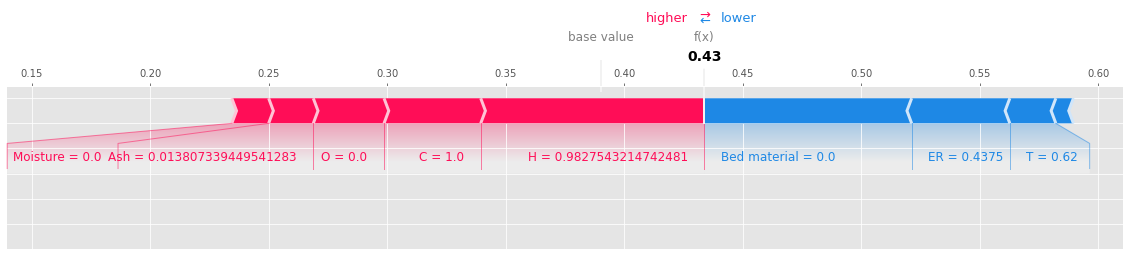

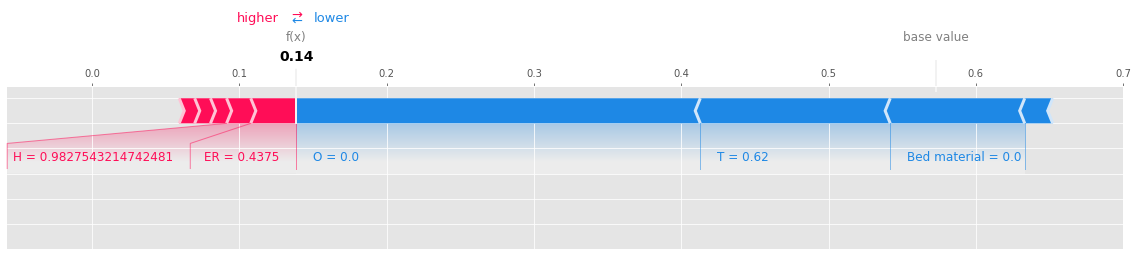

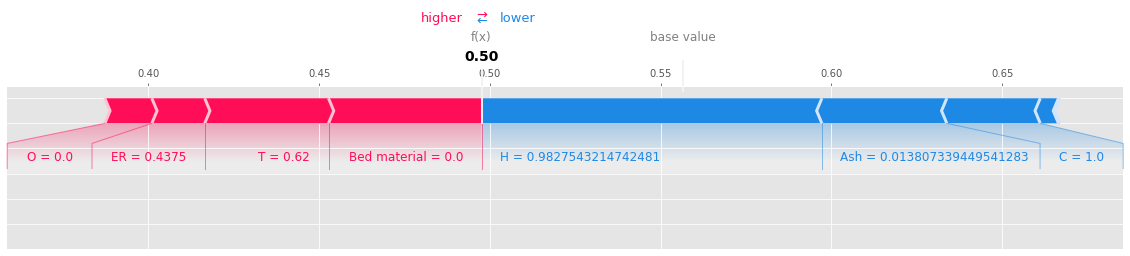

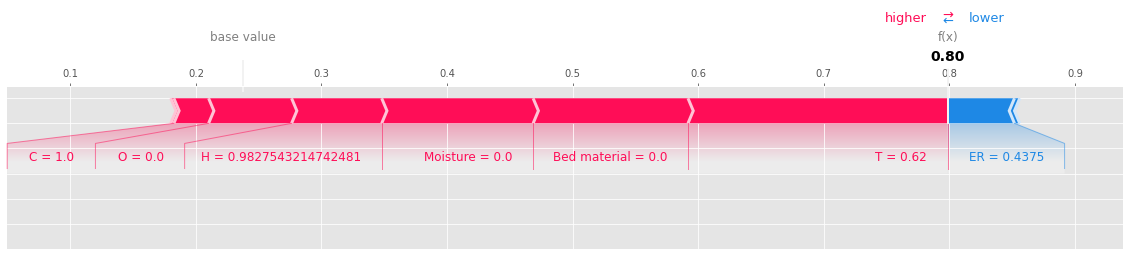

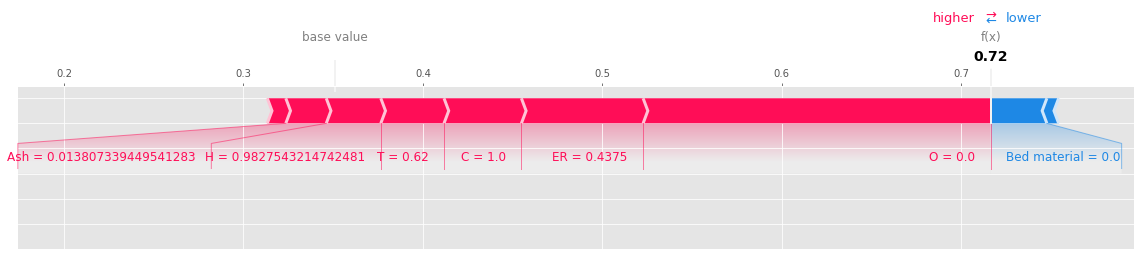

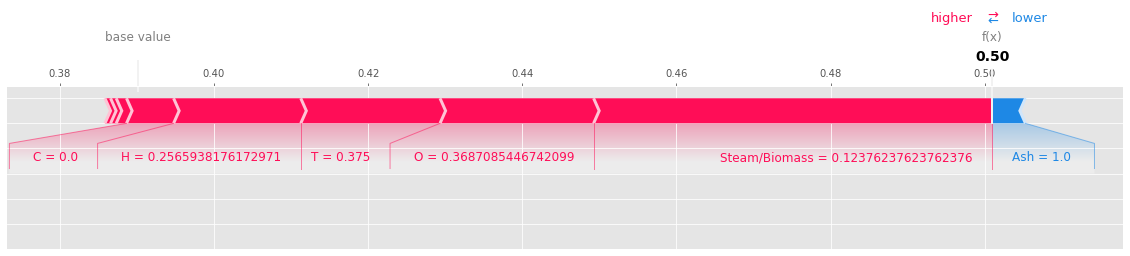

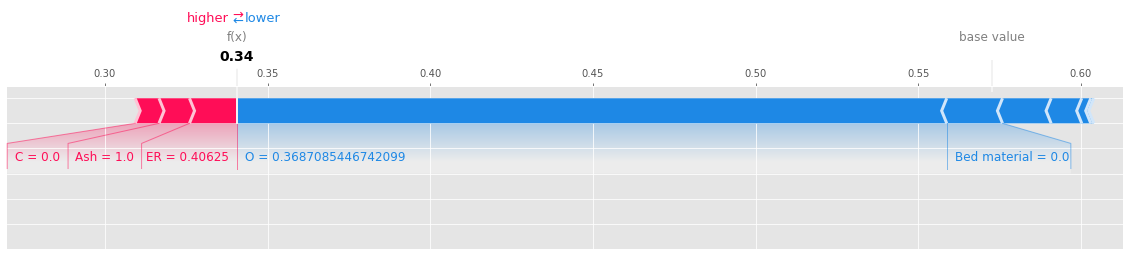

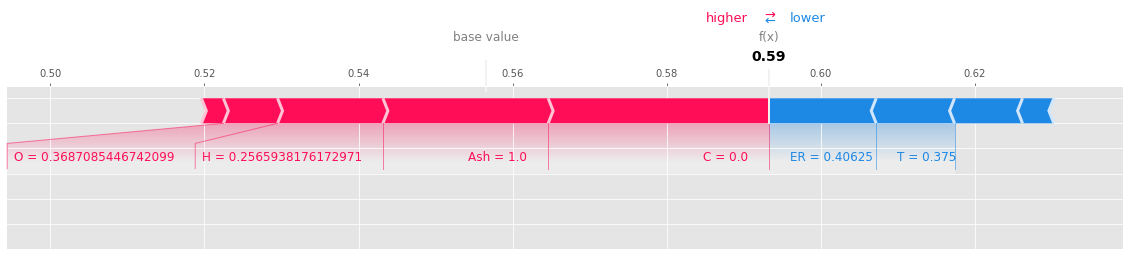

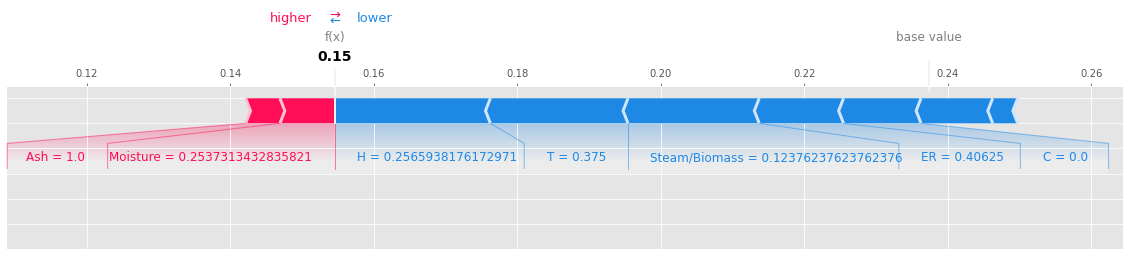

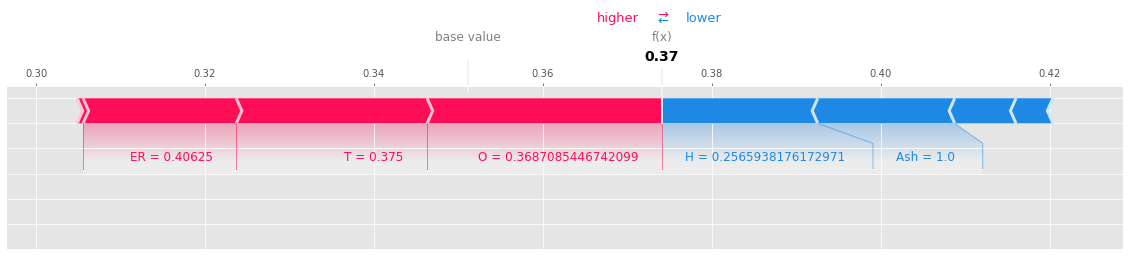

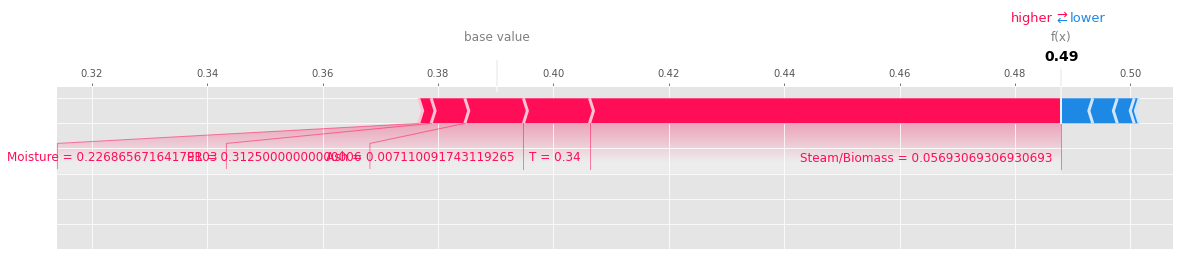

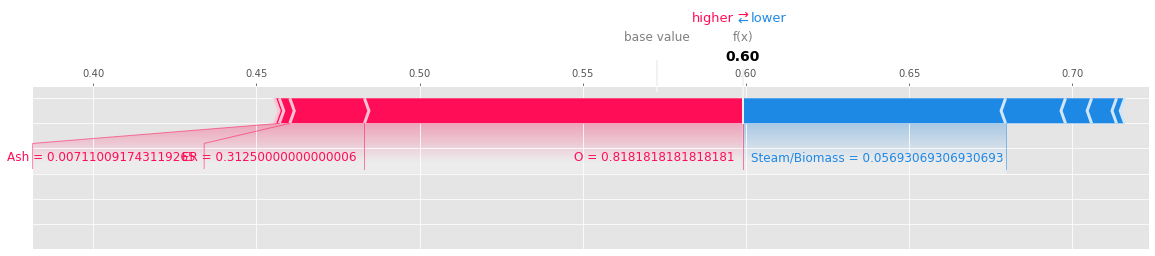

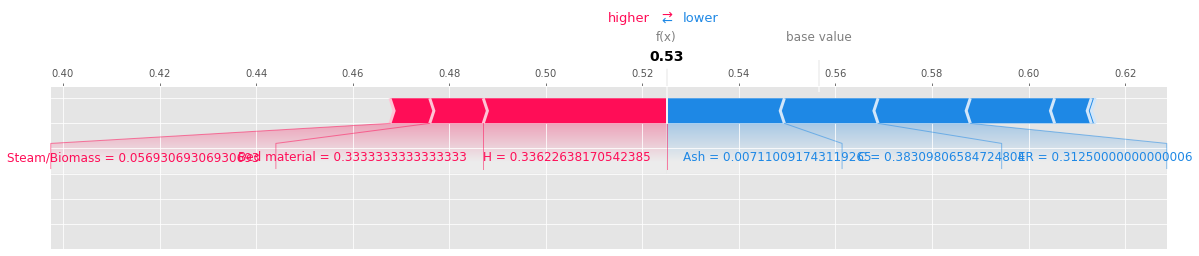

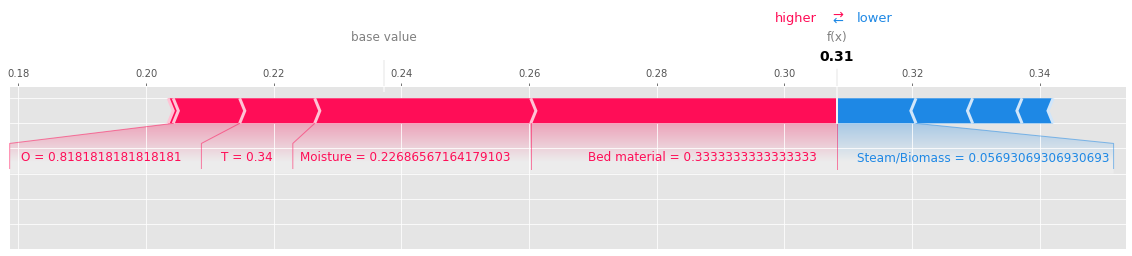

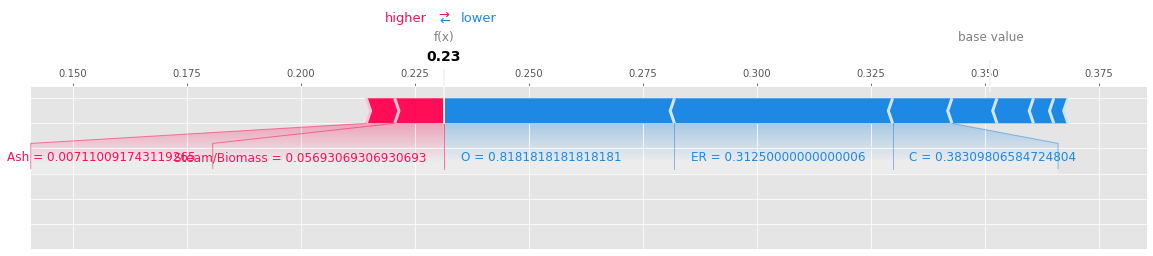

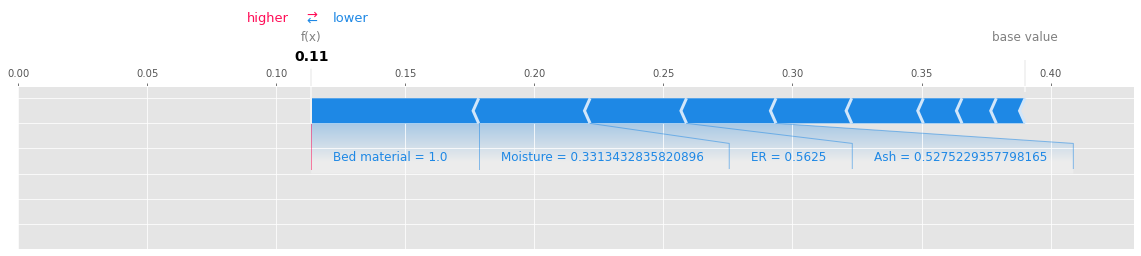

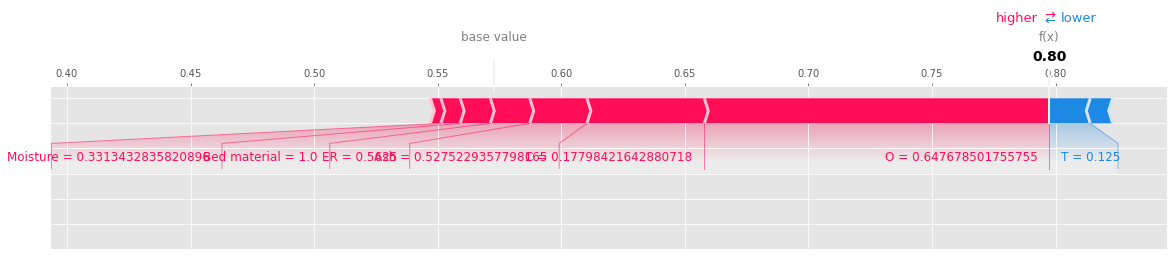

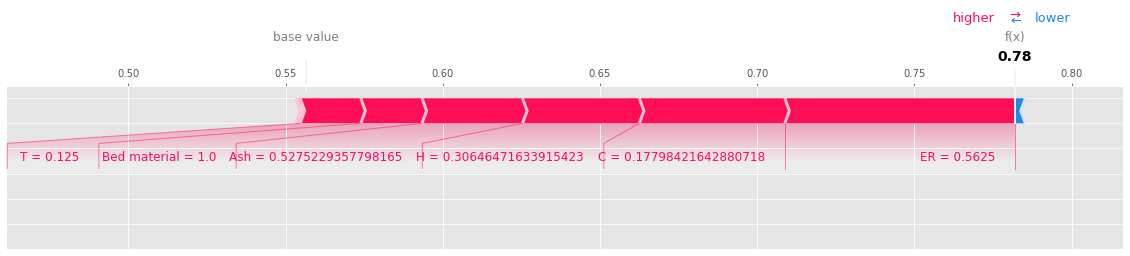

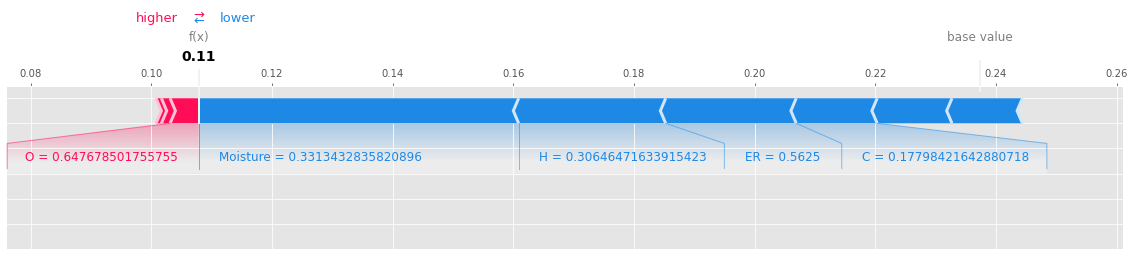

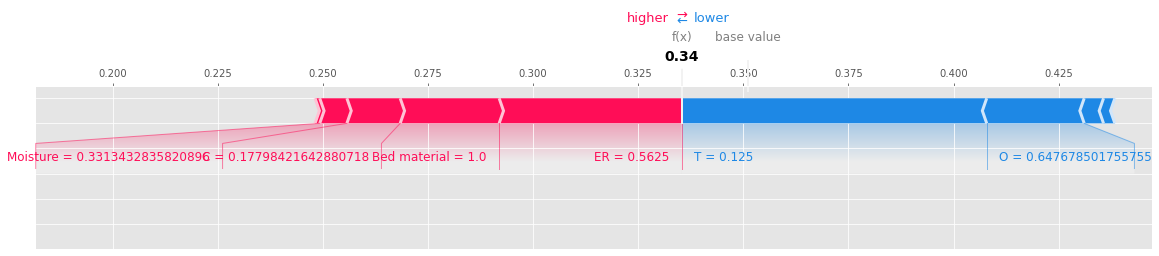

In [65]:
plt.figure()
instance=[0, 2, 4, 5]
for j in instance:
    for odx, out in enumerate(output_columns):
        shap_plot(odx, j)
        plt.savefig(result_folder + 'local_interpretation_dependence_plot_%s_instance_%d.pdf' % (out, j))

## Decision Plots

In [71]:
column = len(output_columns)
# plt.figure(figsize=(5,5))
for odx, out in enumerate(output_columns):
    explainer = shap.TreeExplainer(gbm[idx])
    expected_value = explainer.expected_value
    shap_values = explainer.shap_values(X_test)
    shap.decision_plot(expected_value, shap_values, feature_names=input_columns, show=False)
    plt.title("%s" % out)
#     plt.xlim(-0.25, 0.25)
    plt.tight_layout()
    plt.savefig(result_folder + 'global_interpretation_decision_plot_%s.pdf' % out)
    plt.clf()

<Figure size 576x367.2 with 0 Axes>

In [ ]:
X,y = shap.datasets.adult()
model = xgboost.XGBClassifier().fit(X, y)

explainer = shap.Explainer(model, X)
shap_values = explainer(X)